In [47]:
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load Data

In [37]:
subj_1 = np.load('./subj1.npy',allow_pickle=True).item()
subj_2 = np.load('./subj2.npy',allow_pickle=True).item()
with open('stimuli.txt', "r") as f:
    stimuli = f.readlines()

all_subj = {}
all_subj['subj1'] = subj_1
all_subj['subj2'] = subj_2

subj_1['language'].shape,subj_2['language'].shape,len(stimuli)

((627, 11437), (627, 10791), 627)

In [39]:
rois = list(subj_1.keys())
print(rois)

['language', 'vision', 'dmn', 'task']


## Evaluation Metrics

In [40]:
Y = subj_1['language']

def twoVtwo_acc(Y_gt, Y_pred):
    n = len(Y_gt)
    acc=0
    for i in range(n-1):
        for j in range(i+1,n):
            a = cosine(Y_gt[i], Y_pred[i]) + cosine(Y_gt[j], Y_pred[j])
            b = cosine(Y_gt[i], Y_pred[j]) + cosine(Y_gt[j], Y_pred[i])
            if a<b:
                acc+=1
    return acc/(n*(n-1)/2)

def pearson(Y_gt, Y_pred):
    n = len(Y_gt)
    pcorr=0
    for i in range(n):
        corr = pearsonr(Y_gt[i], Y_pred[i])
        pcorr += corr[0]
    return pcorr/n

# Sentence Representations

## CLS Token Embedding & The Pooled Embeddings.

In [17]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

encoded_inputs = tokenizer(stimuli, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    outputs = model(**encoded_inputs)

cls_embeddings = outputs.last_hidden_state[:, 0, :]
pooled_embeddings = outputs.pooler_output

In [18]:
N,D = cls_embeddings.shape
print('Number of sentences:', N,'\nEmbedding dimension:', D)

Number of sentences: 627 
Embedding dimension: 768


## GloVe Embeddings.

In [19]:
#load glove embeddings
glove = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        glove[word] = vector
#get glove embedding for sentences by averaging word embeddings
#do it for each sentence in stimuli
glove_embeddings = []
for sentence in stimuli:
    words = sentence.split()
    embeddings = []
    for word in words:
        if word in glove:
            embeddings.append(glove[word])
    glove_embeddings.append(np.mean(embeddings, axis=0))
    

In [20]:
len(glove_embeddings),len(glove_embeddings[0])

(627, 100)

In [35]:
all_embeddings = {}
all_embeddings['CLS'] = cls_embeddings.numpy()
all_embeddings['Pooled'] = pooled_embeddings.numpy()
all_embeddings['Glove'] = np.array(glove_embeddings)

# Decoding

In [54]:
decoding_dataframe = pd.DataFrame(columns=['Subject','ROI','Embedding','2v2 accuracy','Pearson'])
for subject in all_subj.keys():
    for roi in rois:
        Y = all_subj[subject][roi]
        for embedding in all_embeddings.keys():
            # print('Subject:',subject,'ROI:',roi,'Embedding:',embedding)
            kfolds = 5
            kf = KFold(n_splits=kfolds)
            acc_ls = []
            pcorr_ls = []
            for train_index, test_index in kf.split(Y):
                X_train, X_test = Y[train_index], Y[test_index]
                Y_train, Y_test = all_embeddings[embedding][train_index], all_embeddings[embedding][test_index]
                reg = LinearRegression().fit(X_train, Y_train)
                Y_pred = reg.predict(X_test)
                acc_ls.append(twoVtwo_acc(Y_test, Y_pred))
                pcorr_ls.append(pearson(Y_test, Y_pred))
            print('Subject:',subject,'ROI:',roi,'Embedding:',embedding,'2v2 accuracy:',np.mean(acc_ls),'Pearson:',np.mean(pcorr_ls))
            decoding_dataframe = decoding_dataframe.append({'Subject':subject,'ROI':roi,'Embedding':embedding,'2v2 accuracy':np.mean(acc_ls),'Pearson':np.mean(pcorr_ls)}, ignore_index=True)

Subject: subj1 ROI: language Embedding: CLS 2v2 accuracy: 0.8510967741935485 Pearson: 0.8068758971638934
Subject: subj1 ROI: language Embedding: Pooled 2v2 accuracy: 0.6653910906298003 Pearson: 0.9100663861380346
Subject: subj1 ROI: language Embedding: Glove 2v2 accuracy: 0.8819858678955453 Pearson: 0.8857100345471796
Subject: subj1 ROI: vision Embedding: CLS 2v2 accuracy: 0.8254410650281618 Pearson: 0.8124908791288756
Subject: subj1 ROI: vision Embedding: Pooled 2v2 accuracy: 0.6437861751152074 Pearson: 0.9086956012141914
Subject: subj1 ROI: vision Embedding: Glove 2v2 accuracy: 0.8872692268305171 Pearson: 0.8908041654857447
Subject: subj1 ROI: dmn Embedding: CLS 2v2 accuracy: 0.830148079877112 Pearson: 0.8167434653219416
Subject: subj1 ROI: dmn Embedding: Pooled 2v2 accuracy: 0.6833323092677931 Pearson: 0.920662775602121
Subject: subj1 ROI: dmn Embedding: Glove 2v2 accuracy: 0.8550533538146443 Pearson: 0.8891478819726479
Subject: subj1 ROI: task Embedding: CLS 2v2 accuracy: 0.8099215

In [55]:
decoding_dataframe

,Subject,ROI,Embedding,2v2 accuracy,Pearson
0,subj1,language,CLS,0.851097,0.806876
1,subj1,language,Pooled,0.665391,0.910066
2,subj1,language,Glove,0.881986,0.885710
3,subj1,vision,CLS,0.825441,0.812491
4,subj1,vision,Pooled,0.643786,0.908696
5,subj1,vision,Glove,0.887269,0.890804
6,subj1,dmn,CLS,0.830148,0.816743
7,subj1,dmn,Pooled,0.683332,0.920663
8,subj1,dmn,Glove,0.855053,0.889148
9,subj1,task,CLS,0.809922,0.831265


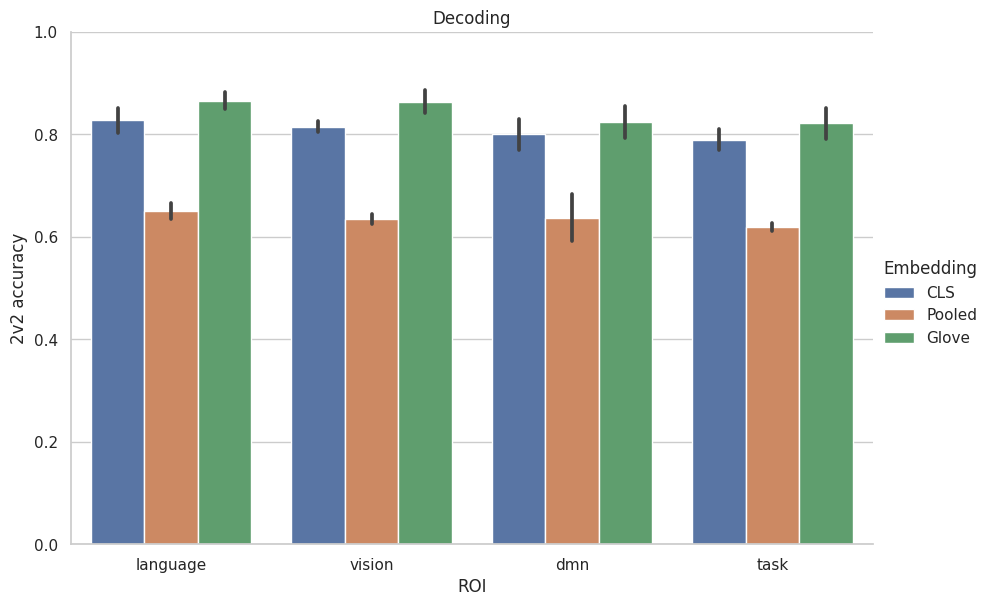

In [63]:
#plot results using seaborn
sns.set(style="whitegrid")
g = sns.catplot(x="ROI", y="2v2 accuracy", hue="Embedding", data=decoding_dataframe, kind="bar", height=6, aspect=1.5)
g.set(ylim=(0, 1))
plt.title('Decoding')
plt.show()

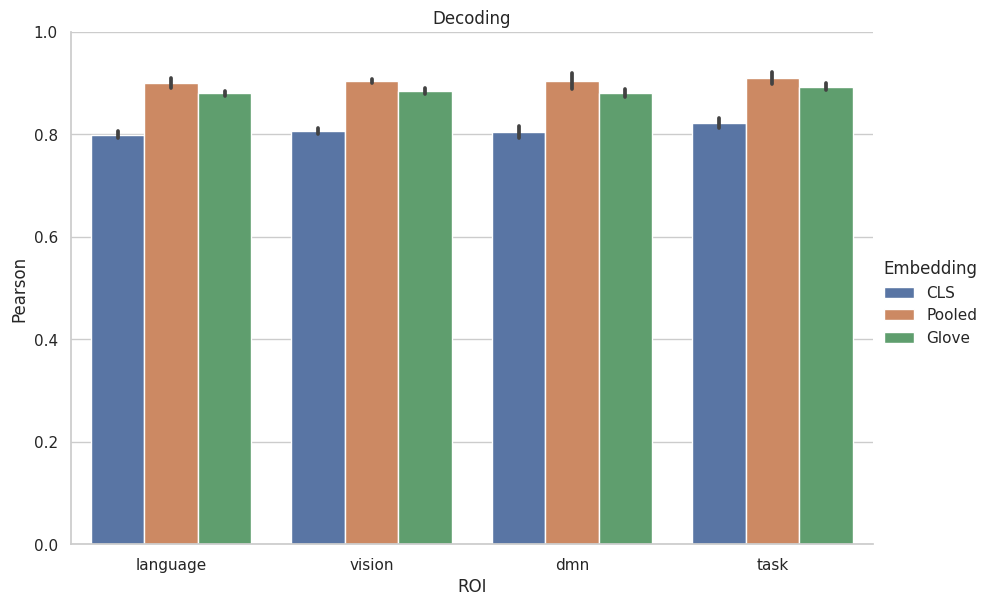

In [62]:
#plot results using seaborn
sns.set(style="whitegrid")
g = sns.catplot(x="ROI", y="Pearson", hue="Embedding", data=decoding_dataframe, kind="bar", height=6, aspect=1.5)
g.set(ylim=(0, 1))
plt.title('Decoding')
plt.show()

### **Decoding:** 
### 2V2 accuracy results:
1. Glove- Decoded better consistently across all RoIs.
2. CLS- Slightly less than Glove.
3. Pooled- Marginally less compared to both.
### Pearson results:
1. Pooled- Decoded better consistently across all RoIs.
2. Glove- Only slightly less than Pooled.
3. CLS- Marginally less compared to both.

# Encoding

In [49]:
encoding_dataframe = pd.DataFrame(columns=['Subject','ROI','Embedding','2v2 accuracy','Pearson'])
for subject in all_subj.keys():
    for roi in rois:
        Y = all_subj[subject][roi]
        for embedding in all_embeddings.keys():
            # print('Subject:',subject,'ROI:',roi,'Embedding:',embedding)
            kfolds = 5
            kf = KFold(n_splits=kfolds)
            acc_ls = []
            pcorr_ls = []
            for train_index, test_index in kf.split(Y):
                Y_train, Y_test = Y[train_index], Y[test_index]
                X_train, X_test = all_embeddings[embedding][train_index], all_embeddings[embedding][test_index]
                reg = LinearRegression().fit(X_train, Y_train)
                Y_pred = reg.predict(X_test)
                acc_ls.append(twoVtwo_acc(Y_test, Y_pred))
                pcorr_ls.append(pearson(Y_test, Y_pred))
            print('Subject:',subject,'ROI:',roi,'Embedding:',embedding,'2v2 accuracy:',np.mean(acc_ls),'Pearson:',np.mean(pcorr_ls))
            encoding_dataframe = encoding_dataframe.append({'Subject':subject,'ROI':roi,'Embedding':embedding,'2v2 accuracy':np.mean(acc_ls),'Pearson':np.mean(pcorr_ls)}, ignore_index=True)


Subject: subj1 ROI: language Embedding: CLS 2v2 accuracy: 0.6089257552483358 Pearson: 0.445051752070321
Subject: subj1 ROI: language Embedding: Pooled 2v2 accuracy: 0.5747596518177163 Pearson: 0.3929168276997694
Subject: subj1 ROI: language Embedding: Glove 2v2 accuracy: 0.7354359447004609 Pearson: 0.7176600535309441
Subject: subj1 ROI: vision Embedding: CLS 2v2 accuracy: 0.5998447516641064 Pearson: 0.5129895546691632
Subject: subj1 ROI: vision Embedding: Pooled 2v2 accuracy: 0.569026113671275 Pearson: 0.4647956784999644
Subject: subj1 ROI: vision Embedding: Glove 2v2 accuracy: 0.7198640040962621 Pearson: 0.7661925197718092
Subject: subj1 ROI: dmn Embedding: CLS 2v2 accuracy: 0.5615283154121864 Pearson: 0.24705082233262027
Subject: subj1 ROI: dmn Embedding: Pooled 2v2 accuracy: 0.5285493087557603 Pearson: 0.2016406597375683
Subject: subj1 ROI: dmn Embedding: Glove 2v2 accuracy: 0.6364804915514592 Pearson: 0.4929946021168285
Subject: subj1 ROI: task Embedding: CLS 2v2 accuracy: 0.552402

In [53]:
encoding_dataframe

,Subject,ROI,Embedding,2v2 accuracy,Pearson
0,subj1,language,CLS,0.608926,0.445052
1,subj1,language,Pooled,0.574760,0.392917
2,subj1,language,Glove,0.735436,0.717660
3,subj1,vision,CLS,0.599845,0.512990
4,subj1,vision,Pooled,0.569026,0.464796
5,subj1,vision,Glove,0.719864,0.766193
6,subj1,dmn,CLS,0.561528,0.247051
7,subj1,dmn,Pooled,0.528549,0.201641
8,subj1,dmn,Glove,0.636480,0.492995
9,subj1,task,CLS,0.552402,0.239425


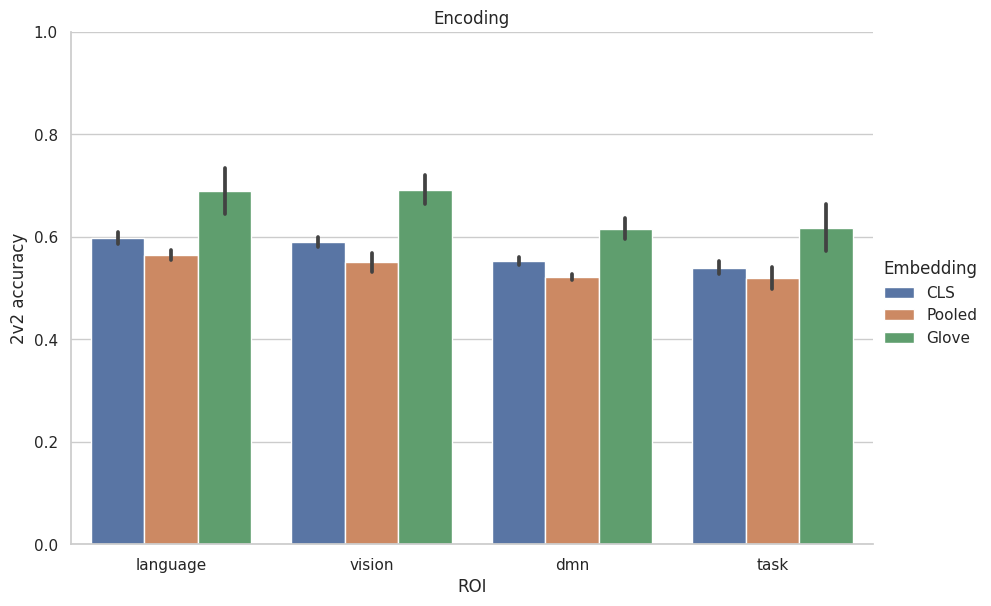

In [60]:
#plot results using seaborn
sns.set(style="whitegrid")
g = sns.catplot(x="ROI", y="2v2 accuracy", hue="Embedding", data=encoding_dataframe, kind="bar", height=6, aspect=1.5)
g.set(ylim=(0, 1))
plt.title('Encoding')
plt.show()

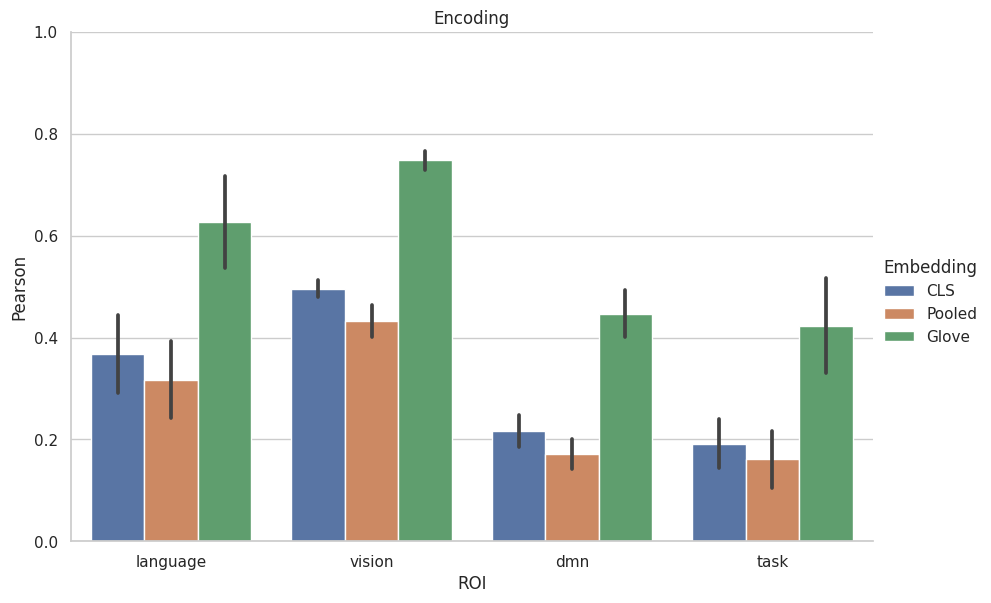

In [61]:
#plot results using seaborn
sns.set(style="whitegrid")
g = sns.catplot(x="ROI", y="Pearson", hue="Embedding", data=encoding_dataframe, kind="bar", height=6, aspect=1.5)
g.set(ylim=(0, 1))
plt.title('Encoding')
plt.show()

### **Encoding:** 
### 2V2 accuracy results:
1. Glove- Performs marginally and consistently better across all RoIs.
2. CLS- Less than Glove across RoIs.
3. Pooled- Slightly less than CLS across RoIS.
### Pearson results:
1. Glove- Performs marginally better than rest across all RoIs.
2. CLS- Less than Glove across RoIs.
3. Pooled- Slightly less than CLS across RoIS.

# Conclusion

- **Task**: [Decoding, Encoding]
   - Results suggests that classification based decoding task is easier to perform than the encoding task. Which may not be true if we try to generate the original stimulus.  
- **RoIs**: ['language', 'vision', 'dmn', 'task']
   - We get to see that all the RoIs were most of the time encoded or decoded correctly but Vision and Language was solved better than other. This may be because the fMRI data was collected such that the subjects had to look at the text and understand it as well leading to relevant activations in Language and Vision RoIs.
- **Embeddings**: ['CLS', 'Pooled', 'Glove']
   - GloVe embeddings excel in capturing broad semantic relationships
   - BERT's CLS token captures contextual information effectively but might not be crucial in tasks where semantic content is paramount.
   - BERT's pooled embeddings lose some contextual nuances compared to the entire sequence representation.